In [1]:
import torch
import cv2

def load_video_to_tensor(video_path: str) -> torch.Tensor:
    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Create an empty list to store the frames
    frames = []

    # Read frames until the video is complete
    while video.isOpened():
        # Read the current frame
        ret, frame = video.read()

        # If the frame is not read successfully, break the loop
        if not ret:
            break

        # Convert the frame to RGB format (assuming BGR format from OpenCV)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Convert the frame to a PyTorch tensor
        frame_tensor = torch.from_numpy(frame_rgb)

        # Append the frame tensor to the list
        frames.append(frame_tensor)

    # Close the video file
    video.release()

    # Stack all the frames in the list along the time dimension
    video_tensor = torch.stack(frames)

    return video_tensor

def print_size(video_tensor: torch.Tensor):
    print(f"size: {video_tensor.element_size() * video_tensor.nelement() / 1024 / 1024} MB")

torch.Size([2475, 1080, 1920, 3])
size: 14683.2275390625 MB


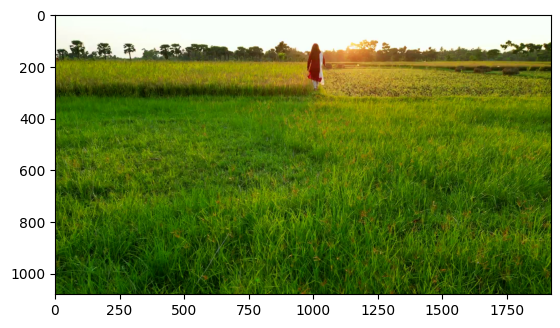

In [2]:
import matplotlib.pyplot as plt

video = load_video_to_tensor(video_path="Drone Shots of our Village.mp4")
print(video.shape)
print_size(video)

plt.imshow(video[0].numpy())
plt.show()

torch.Size([2475, 512, 512, 3])
size: 1856.25 MB


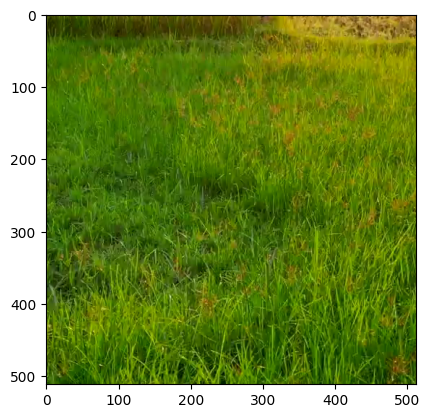

In [3]:
import torchvision.transforms as T
from torchvision.transforms import Compose
import matplotlib.pyplot as plt

transform = Compose([
    T.CenterCrop(512), 
])

video_crop_center = video.permute(3, 0, 1, 2)
video_crop_center = transform(video_crop_center)
video_crop_center = video_crop_center.permute(1, 2, 3, 0)
print(video_crop_center.shape)
print_size(video_crop_center)

plt.imshow(video_crop_center[0].numpy())
plt.show()

torch.Size([2475, 256, 256, 3])
size: 464.0625 MB


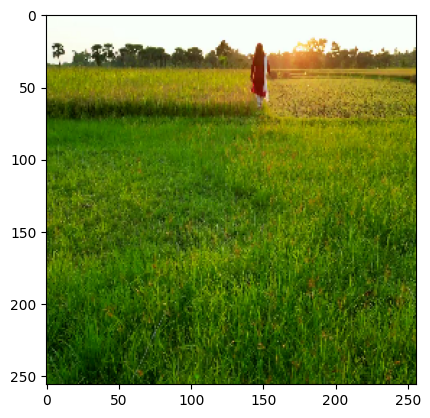

In [3]:
import pytorchvideo.transforms as ptv_transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    ptv_transforms.RandomResizedCrop(256, 256, scale=(0.5, 1.0), aspect_ratio=(3/4, 4/3)),
])

video_crop_random = video.permute(3, 0, 1, 2)
video_crop_random = transform(video_crop_random)
video_crop_random = video_crop_random.permute(1, 2, 3, 0)
print(video_crop_random.shape)
print_size(video_crop_random)

plt.imshow(video_crop_random[0].numpy())
plt.show()

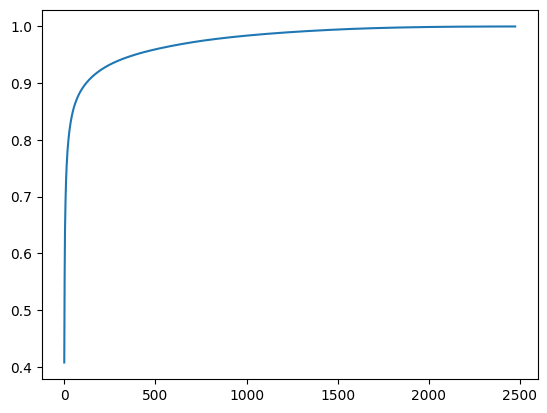

In [13]:
from sklearn.decomposition import PCA
from einops import rearrange

pca = PCA()
video_crop_random_pca = rearrange(video_crop_random, 't h w c -> (h w c) t')
cumulative_explained_variance = pca.fit(video_crop_random_pca).explained_variance_ratio_.cumsum()
plt.plot(cumulative_explained_variance)
plt.show()

In [17]:
# To get 80% of the variance, we need 23 components
# To get 85% of the variance, we need 47 components
# To get 90% of the variance, we need 120 components
# To get 95% of the variance, we need 386 components
# To get 97% of the variance, we need 662 components

found80 = False
found85 = False
found90 = False
found95 = False
found97 = False

for i, v in enumerate(cumulative_explained_variance):
    if v > 0.80 and not found80:
        print(i)
        found80 = True
    if v > 0.85 and not found85:
        print(i)
        found85 = True
    if v > 0.90 and not found90:
        print(i)
        found90 = True
    if v > 0.95 and not found95:
        print(i)
        found95 = True
    if v > 0.97 and not found97:
        print(i)
        found97 = True

23
47
120
386
662


In [ ]:
del video, video_crop_center

video = video_crop_random

del video_crop_random

In [ ]:
from diffusers import DiffusionPipeline
pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", revision="fp16", torch_dtype=torch.float16)
vae = pipe.vae
del pipe

vae.enable_slicing()
vae.enable_tiling()

/Users/tim/anaconda3/envs/lcvideo/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/Users/tim/anaconda3/envs/lcvideo/lib/python3.11/site-packages/diffusers/pipelines/pipeline_utils.py:270: FutureWarning: You are loading the variant fp16 from runwayml/stable-diffusion-v1-5 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
/Users/tim/anaconda3/envs/lcvideo/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
vae/diffusion_pytorch_model.safetensors not found

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/Users/tim/anaconda3/envs/lcvideo/lib/python3.11/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
video = video.permute(0, 3, 1, 2)

video = video.to(torch.float16)

vae = vae.to("mps")
video = video.to("mps")

In [ ]:
video.shape

torch.Size([2475, 3, 256, 256])

In [ ]:
latent_videos = []
for i in range(0, video.shape[0], 8):
    print(f"Processing frames {i} to {i+8}")
    latent_videos.append(vae.encode(video[i:i+8], return_dict=False)[0].sample().to("cpu"))

Processing frames 0 to 8
Processing frames 8 to 16
Processing frames 16 to 24


RuntimeError: MPS backend out of memory (MPS allocated: 18.08 GB, other allocations: 52.92 MB, max allowed: 18.13 GB). Tried to allocate 2.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
latent_videos = torch.cat(latent_videos, dim=0)
latent_videos.shape

torch.Size([8, 4, 32, 32])